In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import numpy as np
import plotnine as p9
pd.options.display.max_columns= None
from sklearn.preprocessing import minmax_scale

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

mytheme = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text=p9.element_text(size=17),
                 figure_size = (10, 7.5),
                 subplots_adjust={'hspace': 0.31}
             )
            )

mythemewide = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text= p9.element_text(size=17),
                 figure_size = (15, 7.5),
                 subplots_adjust={'hspace': 0.31}
             )
            )

mythemewider= (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text= p9.element_text(size=17),
                 figure_size = (15, 5),
                 subplots_adjust={'hspace': 0.31}
             )
            )

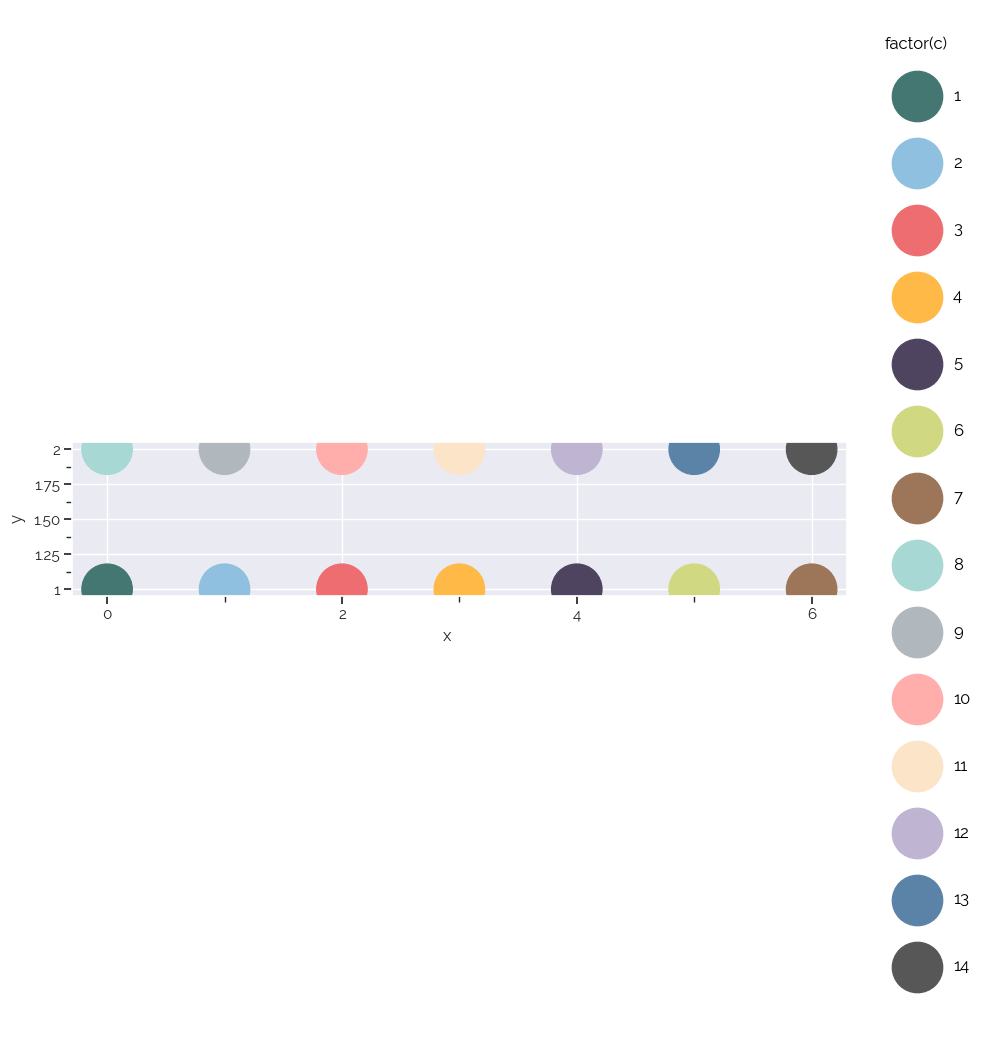

In [2]:
# color scheme

mycolorsold = ['#447672', '#EA9F7E', '#DABFFF', '#B4D2BA', '#F4D35E', 
            '#7cbcb7', '#67555C', '#F6D8AE', '#ABA8B2', '#7B3E19', 
            '#0C4767', '#93B7BE', '#7B886B', '#bbbf76', '#F17300']

mycolors = ['#447672', '#8fc0e0', '#ee6d71', '#ffb947', '#4e445f', '#d1d882', '#9D7558', 
            '#a7d8d4', '#b0b7bd', '#ffaeac', '#fce4c9', '#bfb4d2', '#5b83a8', '#575757']
p9.options.figure_size = (10, 2)
x = list(range(7))*2
y = [1]*7+[2]*7
c = list(range(1,15))


(
    p9.ggplot(p9.aes('x' , 'y', color='factor(c)')) 
    + p9.geom_point(size=20)
    + p9.scale_color_manual(mycolors)
    + p9.theme_seaborn()
).draw();

In [3]:
data = pd.read_csv('barkbeetle_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
data.describe().round(2)

,fdist_id,year,infested_wood,disposed_wood,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,area_fdist,endangered_forest_density,TX0,TM0,TN0,RF0,SD0,RRU,RRK,FF1,FF2,FFB,RGK,ETP,GRV,KWU,KWK,HS8,HS16,prev_disposed_wood,prev_infested_wood,prev_infested_wood_ofo,TX0_rollyr,TM0_rollyr,TN0_rollyr,RF0_rollyr,SD0_rollyr,RRU_rollyr,RRK_rollyr,FF1_rollyr,FF2_rollyr,FFB_rollyr,RGK_rollyr,ETP_rollyr,GRV_rollyr,KWU_rollyr,KWK_rollyr,prev_infested_wood_rollyr,prev_disposed_wood_rollyr,HS8_rollyr,HS16_rollyr,TX0_rollsr,TM0_rollsr,TN0_rollsr,RF0_rollsr,SD0_rollsr,RRU_rollsr,RRK_rollsr,FF1_rollsr,FF2_rollsr,FFB_rollsr,RGK_rollsr,ETP_rollsr,GRV_rollsr,KWU_rollsr,KWK_rollsr,TX0_rollwr,TM0_rollwr,TN0_rollwr,RF0_rollwr,SD0_rollwr,RRU_rollwr,RRK_rollwr,FF1_rollwr,FF2_rollwr,FFB_rollwr,RGK_rollwr,ETP_rollwr,GRV_rollwr,KWU_rollwr,KWK_rollwr,area_endangered,demolition_wood,disposed_demolition_wood,disposing_rate_demolition,disposing_rate_infested_yr
count,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,13484.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,12848.00,13376.00,13376.00,13376.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12620.00,0.0,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,12092.00,13484.00,13484.00,13484.00,13484.00,3216.0
mean,2408.01,2012.44,333.46,228.39,1193.25,4285.47,1755.62,2577.67,388573.97,5651744.90,347.54,1077.71,16.87,11.95,6.94,74.75,217.55,93.30,103.07,3.40,2.49,2.48,128.20,85.32,80.98,7.97,17.75,185.05,185.05,212.67,317.85,317.85,13.50,9.13,4.69,77.51,229.15,116.14,129.85,3.62,2.65,2.59,126.41,80.94,74.06,35.19,48.90,2187.49,NaN,1489.44,1489.44,20.39,14.90,9.31,72.10,206.81,70.44,76.19,3.16,2.31,2.37,130.81,90.36,88.34,-19.92,-14.16,2.20,1.12,0.02,27.64,83.83,53.95,61.17,1.36,1.00,0.94,40.67,23.84,19.92,30.10,37.32,1474.43,1824.51,881.26,0.79,1.0
std,420.09,4.58,2447.14,1445.03,1095.22,2506.54,2643.74,2481.59,58410.74,37114.84,179.39,1286.34,7.17,6.14,5.20,7.18,56.44,60.30,67.51,0.73,0.54,0.35,27.01,21.80,25.77,70.50,77.72,148.36,148.36,1386.56,2377.68,2377.68,1.57,1.32,1.10,2.79,24.99,25.43,28.61,0.52,0.38,0.24,7.12,5.67,8.16,29.15,32.33,13125.97,NaN,249.58,249.58,1.63,1.26,0.93,3.50,20.15,19.98,20.97,0.45,0.33,0.22,7.16,6.22,8.23,24.75,25.78,0.61,0.55,0.51,0.87,13.67,13.48,15.39,0.21,0.15,0.09,3.61,2.47,3.26,14.84,16.75,2042.92,8614.27,4106.38,0.30,0.0
min,1101.00,2005.00,0.00,0.00,0.00,1095.90,0.00,5.58,291131.34,5576753.53,125.18,0.00,-0.99,-3.38,-6.54,52.62,68.53,0.15,0.32,1.66,1.25,1.54,53.74,31.52,26.35,-147.90,-147.04,0.00,0.00,0.00,0.00,0.00,8.72,5.17,1.16,69.85,162.45,60.32,67.60,2.40,1.75,1.97,104.85,65.53,54.29,-31.48,-24.19,0.00,NaN,800.98,800.98,15.73,11.53,6.62,60.69,160.45,21.36,23.67,2.12,1.56,1.80,114.03,74.67,67.67,-86.09,-83.78,0.57,-0.40,-1.51,25.57,49.21,21.63,25.31,0.88,0.64,0.69,25.45,16.09,11.60,-6.07,-2.59,0.00,0.00,0.00,0.00,1.0
25%,2202.00,2008.00,0.00,0.00,173.07,2324.07,24.17,568.67,340650.38,5620665.56,233.58,94.79,10.76,6.98,2.75,69.22,183.81,45.03,49.56,2.88,2.11,2.23,106.71,67.85,59.41,-42.80,-37.97,36.44,36.44,0.00,0.00,0.00,12.46,8.24,3.95,75.96,209.20,97.43,108.78,3.29,2.42,2.44,121.01,76.88,68.27,14.29,25.74,0.00,NaN,1314.42,1314.42,19.39,14.08,8.65,70.20,192.84,56.84,62.09,2.89,2.12,2.23,125.92,86.17,82.83,-35.43,-30.28,1.75,0.72,-0.36,27.02,72.54,44.89,50.83,1.23,0.90,0.88,37.97,21.90,17.51,20.46,26.39,82.46,0.00,0.00,0.62,1.0
50%,2503.00,2012.00,0.93,0.00,1028.08,3328.44,483.53,1973.92,383811.53,5657903.85,272.44,518.09,18.68,13.38,7.99,74.63,216.33,80.71,88.21,3.28,2.41,2.44,132.74,83.93,78.7

First, plot a map with the total number of newly damaged wood over the whole time period

To get a first impression of the data, we create a chloropleth map in which the total amount of obsereved infested wood (all observations) is shaded in for every forestry district. Since there is a different area of endangered forest (endangered = tree height above 20 metres as well as a spruce tree ratio of 10%) in every forestry district, we also overlay a bubble map where the bubble size represents the total area of endangered forest.

### History of infested wood obervations

In [7]:
import matplotlib.colors as mcolors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
# read shapefile with geodata since we need it to plot the map
# we only need the first 53 rows since these are the current districts
districts_gdf = gpd.read_file(r'forestry_districts.shp', encoding='utf-8').loc[:53]

districts_gdf.columns = ['county_name', 'fdist_name', 'fdist_id', 'area_nse', 'area_nsne', 
                         'area_se', 'area_sne', 'area_fdist', 'endangered_forest_density', 
                         'centroid_xcoord', 'centroid_ycoord', 'geometry']

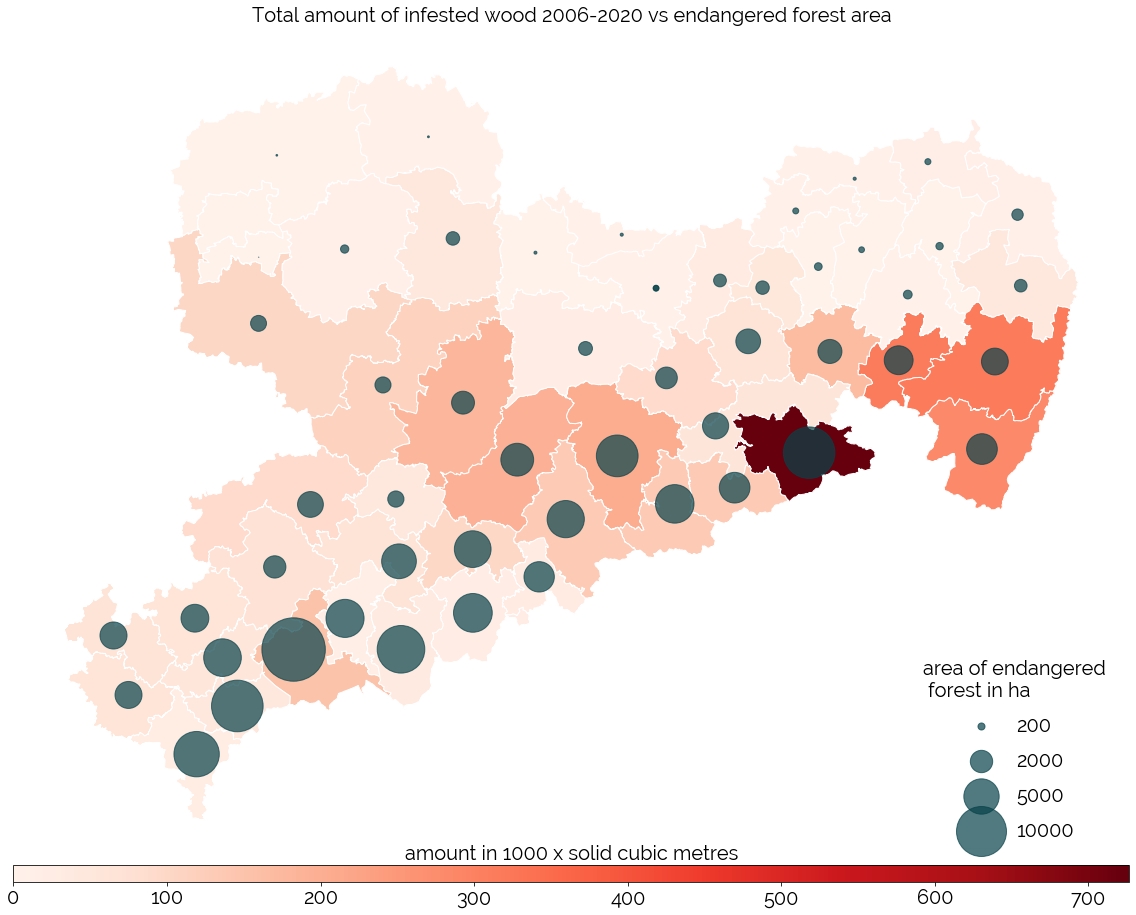

In [9]:
# get the total amount of damaged wood for every forestry district
total_infested_wood = data.groupby('fdist_name')['infested_wood'].sum()

# map information on total amount of damaged wood from dataset to the geodataframe entries
districts_gdf['total_infested_wood'] = [total_infested_wood.loc[total_infested_wood.index == district_name].item()/1000 for district_name in districts_gdf['fdist_name']]

# create column with total amount of endangered forest area (add private and state owned together)
# scale by 0.25 to get the right bubble sizes, later scale the same amount in legend
area_scale = .25
districts_gdf['area_endangered'] = (districts_gdf['area_nse'] + districts_gdf['area_se']) * area_scale


# create plot
fig, ax = plt.subplots(figsize=(20,20))

# plot title
plt.title('Total amount of infested wood 2006-2020 vs endangered forest area', fontdict={'fontsize': 20})

# custom legend for colormap requires locateable axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=0.1) # colormap parameters

# plot the forestry districts chloropleth map

districts_gdf.plot(ax=ax, column='total_infested_wood', legend=True, cax=cax,
          edgecolor='white', linewidth=1, legend_kwds={'orientation': 'horizontal'},
          cmap=truncate_colormap(plt.get_cmap('Reds'), 0.02, 1))


# colormap legend title and ticks
plt.title('amount in 1000 x solid cubic metres', fontdict={'fontsize': 20})
cax.tick_params(labelsize=20)


#counties_gdf = districts_gdf.dissolve(by='KREIS_NAME')
#counties_gdf.plot(ax=ax, legend=True, color='none',
#                edgecolor='black', linewidth=.5)

# bubble map 
# calculate representative points from polygons (used as bubble location)
gdf_points = districts_gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].representative_point()
# plot bubbles
gdf_points.plot(ax=ax, color='#07424A', markersize='area_endangered', alpha=.7, categorical=False, legend=True)

# make some dummy points at 0,0 to use as custom legend handles in the bubble plot legend
ax.scatter([0], [0], c='#07424A', alpha=.7, s=200*area_scale,
            label='200')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=2000*area_scale,
            label='2000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=5000*area_scale,
            label='5000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=10000*area_scale,
            label='10000')

# add bubble map legend
ax.legend(scatterpoints=1, frameon=True,
        labelspacing=.8, loc='lower right', fontsize=20, edgecolor='white',
        bbox_to_anchor=(1,0), title_fontsize=20, title='area of endangered \n forest in ha');

# x and y axis settings
ax.set_xlim(267100.4013500002, 514160.39804999967);
ax.set_ylim(5552730.938154999, 5736554.970745001);
ax.axis('off');


We can also print out th top and bottom values to supplement the plot:

In [10]:
# first restore the original amount of damaged wood and endangered forest area (revert scale)
districts_gdf['area_endangered'] = districts_gdf['area_endangered']/area_scale
districts_gdf['total_infested_wood'] = districts_gdf['total_infested_wood']*1000

# get top and bottom rows regarding amount of damaged wood
district_info = districts_gdf[['county_name', 'fdist_name', 'total_infested_wood', 'area_endangered']].sort_values('total_infested_wood', ascending=False)
district_info.head(4).append(district_info.tail(4))

,county_name,fdist_name,total_infested_wood,area_endangered
38,Sächsische Schweiz-Osterzgebirge,Sebnitz,726589.19,10611.80
42,Görlitz,Löbau,317423.00,2879.04
20,Bautzen,Cunewalde,314677.26,3332.18
19,Görlitz,Zittau,283009.66,3772.59
6,Nordsachsen,Delitzsch,313.14,11.40
14,Meißen,M West,85.00,36.16
48,Kreisfreie Stadt Leipzig,Connewitz,0.00,0.54
49,Kreisfreie Stadt Leipzig,Leutzsch,0.00,0.00


The first thing that catches the eye is the dark red shade of the *Sebnitz* district. The amount of total observed damaged wood far exceeds that of the other forestry districts. Some correlation exists between the amount of damaged wood and the area of endangered forest. However there are also other factors at play. Although the area of endangered forest of the forestry districts of the *Görlitz* county in the east and the *Erzgebirgskreis* in the central south are comparable, *Görlitz* has much higher amounts of damaged wood.

Let's take a closer look at relationship between area of endangered forest and amount of damaged wood. 

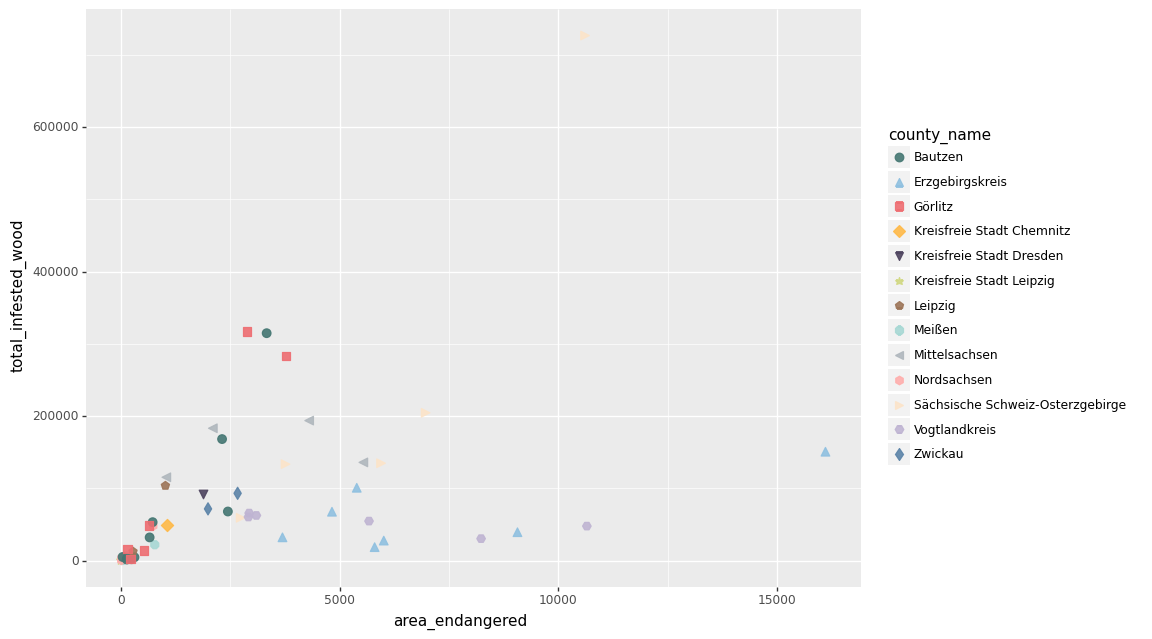

In [11]:
p9.options.figure_size = (10, 7.5)

(
    p9.ggplot(districts_gdf, p9.aes('area_endangered' , 'total_infested_wood', color='county_name')) 
    + p9.geom_point(p9.aes(shape='county_name'), size=3, alpha=.9)
    + p9.scale_color_manual(mycolors[:13])
).draw();



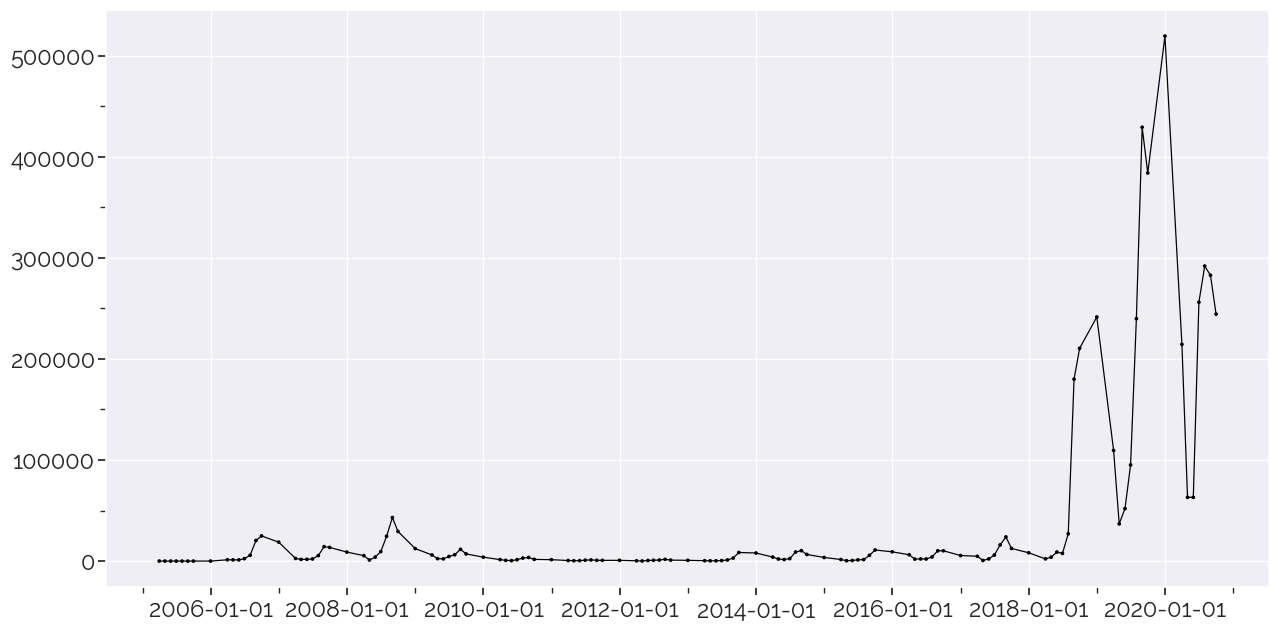

In [12]:

(
    p9.ggplot(p9.aes(data.groupby('timestamp')['infested_wood'].sum().index, data.groupby('timestamp')['infested_wood'].sum().values)) 
    + p9.geom_line()
    + p9.geom_point(size=.5)
    + mythemewide
).draw();

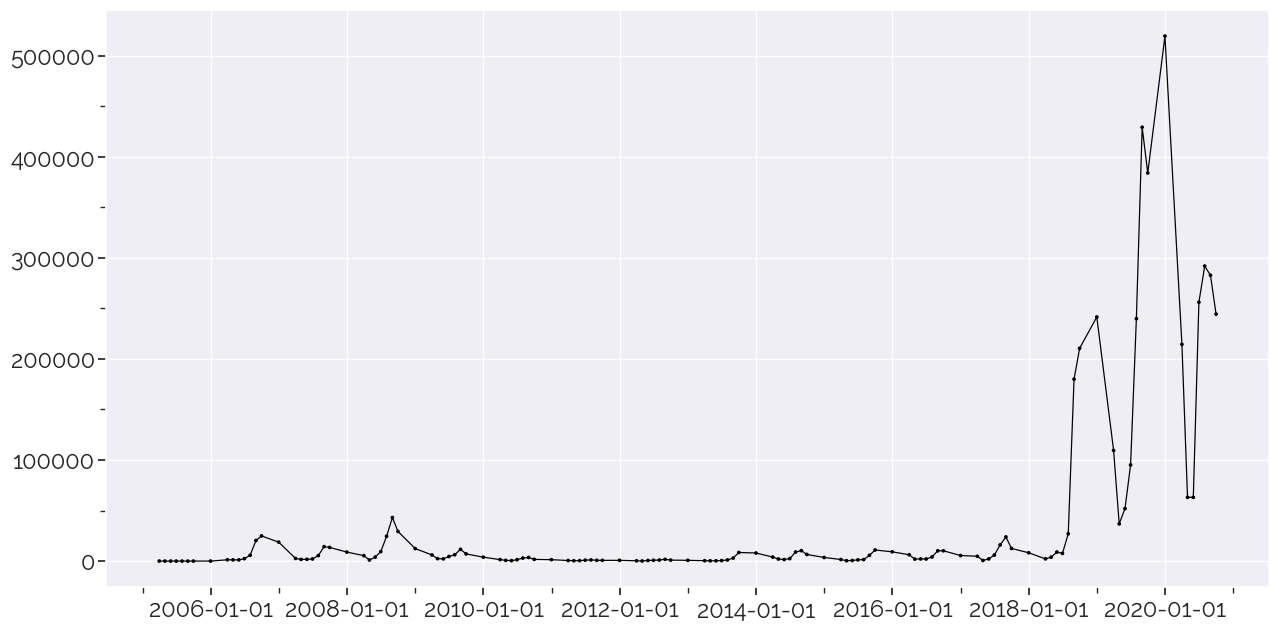

In [13]:
(
    p9.ggplot(p9.aes(data.groupby('timestamp')['infested_wood'].sum().index, data.groupby('timestamp')['infested_wood'].sum().values)) 
    + p9.geom_line()
    + p9.geom_point(size=.5)
    + mythemewide
).draw();

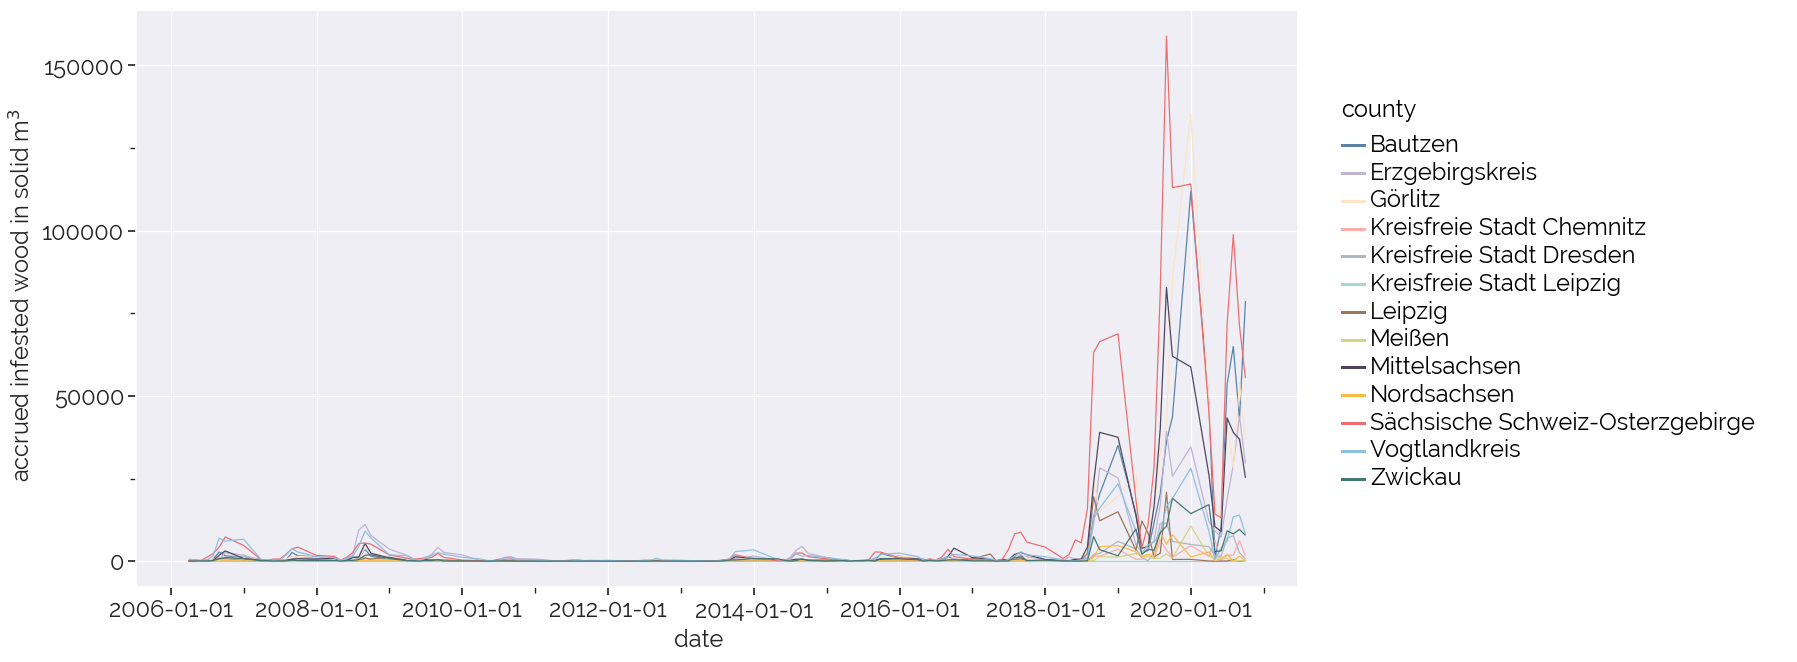

In [14]:
grouped_by_county = data[data['year'] > 2005].groupby(['timestamp','county_name'])['infested_wood'].sum().reset_index()

(
    p9.ggplot(grouped_by_county, p9.aes('timestamp', 'infested_wood', color='county_name'))
    + p9.geom_line()
    + p9.scale_color_manual(mycolors[:13][::-1], name='county')
    + p9.xlab('date') + p9.ylab('accrued infested wood in solid m$^3$')
    + mythemewide
).draw();

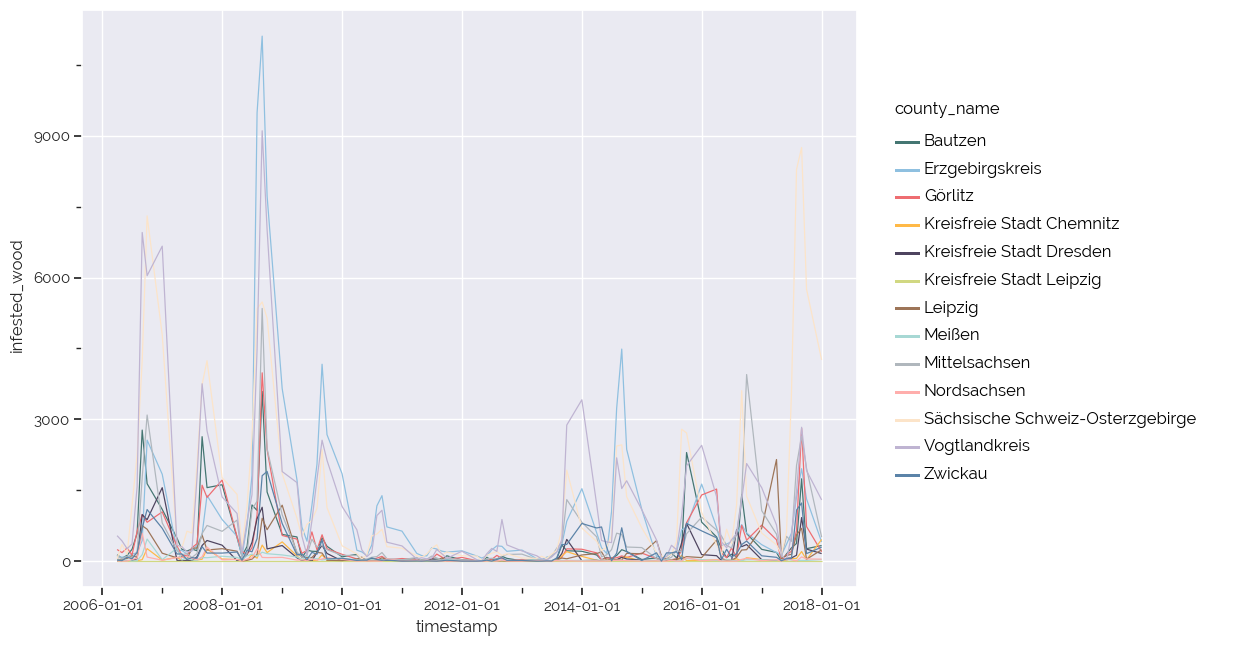

In [15]:
(
    p9.ggplot(grouped_by_county[grouped_by_county['timestamp'] < pd.Timestamp('2018-01-01')], p9.aes('timestamp', 'infested_wood', color='county_name')) 
    + p9.geom_line()
    + p9.scale_color_manual(mycolors[:13])
    + p9.theme_seaborn()
).draw();

In [16]:
data[(data['infested_wood']>0) & (data['infested_wood']<=100)].shape

(4552, 93)

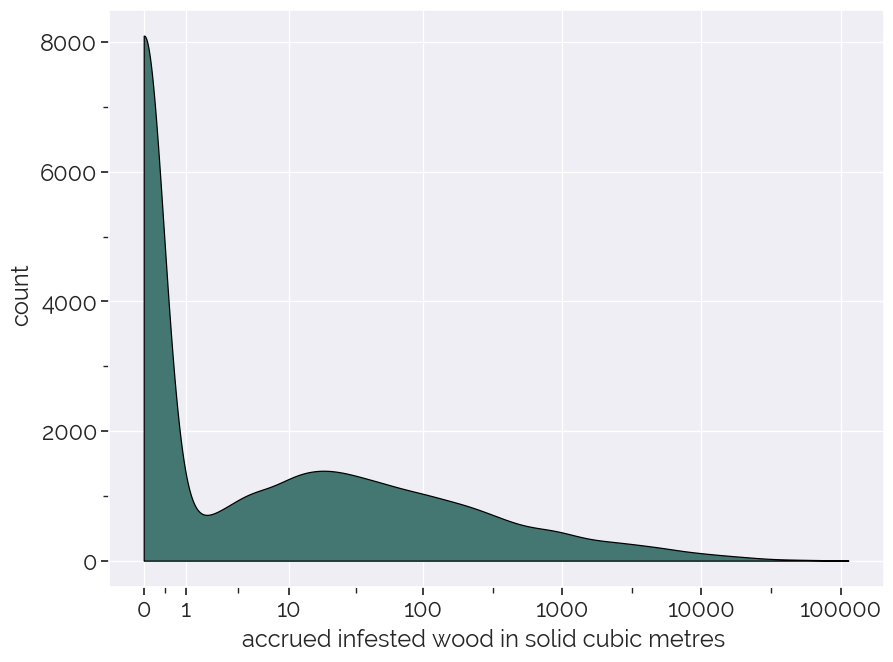

In [17]:
#TODO: Histogram of observations
(
    p9.ggplot(data, p9.aes(x='infested_wood')) 
    + p9.geom_density(p9.aes(y='..count..'), fill=mycolors[0])
    + p9.theme_seaborn()
    + p9.scale_x_continuous(trans="log1p", breaks=[0,1,10,100,1000,10000, 100000])
    + p9.xlab('accrued infested wood in solid cubic metres') + p9.ylab('count')
    + mytheme
).draw();


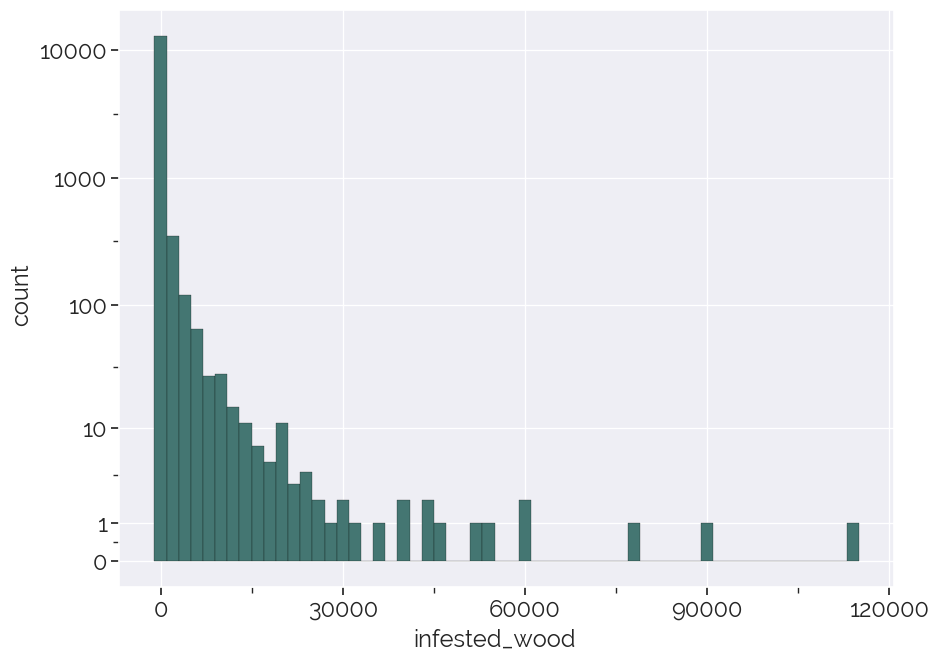

In [18]:
#TODO: Histogram of observations

p9.options.figure_size = (10, 7.5)

(
    p9.ggplot(data, p9.aes(x='infested_wood')) 
    + p9.geom_histogram(binwidth=2000, fill=mycolors[0], color='black', size=.1)
    + p9.scale_y_continuous(trans="log1p", breaks=[0,1,10,100,1000,10000])
    + mytheme
).draw();


# Meteorological

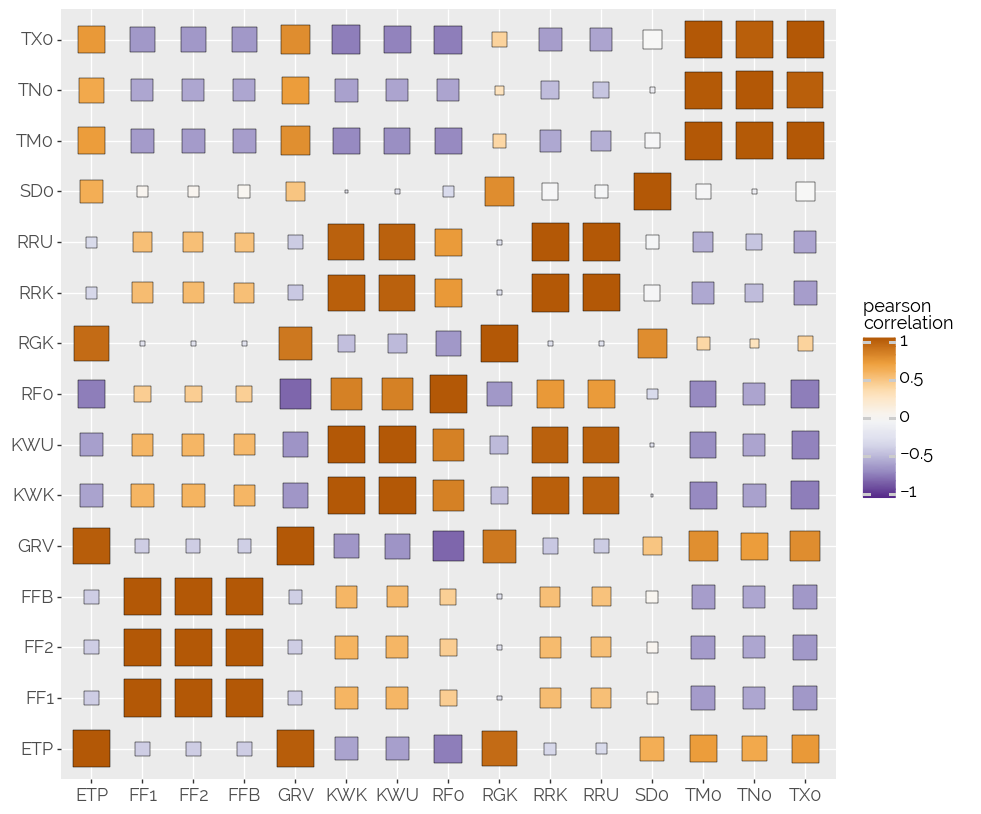

In [19]:
def heatmap(x, y, size, color):
    p9.options.figure_size = (10,10)
    (p9.ggplot(p9.aes(x,y, size=size, fill=color, group=1))
    + p9.geom_point(shape='s', stroke=.2#, position=p9.position_nudge(x=-0.5, y=-0.5)
                   )
    + p9.scale_fill_distiller(
        type='div',
        name='pearson \ncorrelation\n', 
        limits=[-1,1],
        palette=4)
     + p9.scale_size_continuous(range=[-10,15], limits=[0,1], guide=False)
     + p9.xlab('') + p9.ylab('')
     + p9.theme(text= p9.element_text(size=13, family='sans-serif'))
    ).draw();

    

columns = [
    'TX0', # maximum temperature of the day in degrees Celsius
    'TM0', # mean temperature of the day in degrees Celsius
    'TN0', # minimum temperature of the day in degrees Celsius
    'RF0', # mean relative humidity of the day in %
    'SD0', # total sunshine duration of the day in h
    'RRU', # total precipitation of the day in mm
    'RRK', # corrected total precipitation of the day in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
    'FF1', # mean wind velocity of the day 10 metres above ground in m*s-1
    'FF2', # mean wind velocity of the day 2 metres above ground in m*s-1
    'FFB', # wind speed of the day on the beaufort scale in bft
    'RGK', # total global solar irradiation of the day in kWh*m-2
    'ETP', # potential evaporation for the day in mm
    'GRV', # potential evapotranspiration for the day in mm
    'KWU', # 
    'KWK'
]


corr = data[columns].corr()
# Unpivot the dataframe, so we can get pair of arrays for x and y
corr = pd.melt(corr.reset_index(), id_vars='index') 
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
)

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


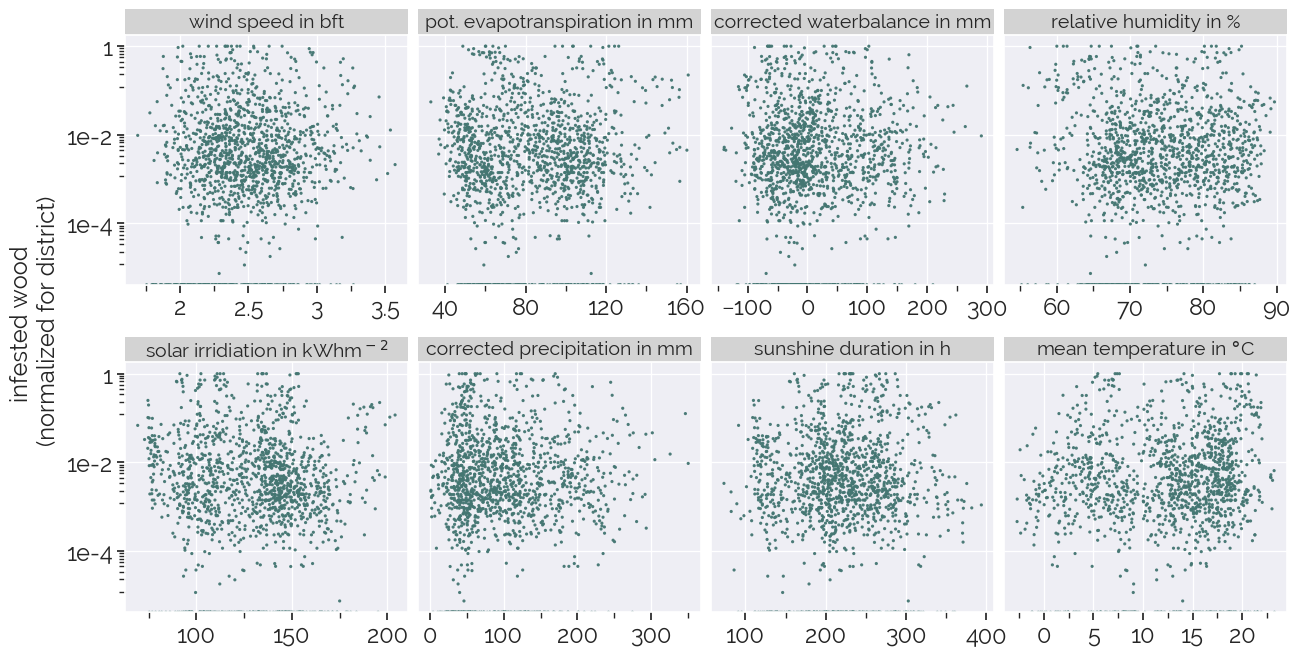

In [20]:
# Initial graphic

def mylabeller(var):
    label_dict = {
        'FFB': 'wind speed in bft',
        'GRV': 'pot. evapotranspiration in mm',
        'KWK': 'corrected waterbalance in mm',
        'RF0': 'relative humidity in %',
        'RGK': r'solar irridiation in kWhm$^-$$^2$',
        'RRK': 'corrected precipitation in mm',
        'SD0': 'sunshine duration in h',
        'TM0': 'mean temperature in $°$C',
    }
    return label_dict.get(var)


draw = data[(data['year'].isin(range(2006,2020)))].copy()
draw['infested_wood'] = draw.groupby(['county_name', 'timestamp'])['infested_wood'].transform('sum')
for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['county_name', 'timestamp'])[v].transform('mean')
draw.drop_duplicates(['county_name', 'timestamp'], inplace=True)
draw['infested_wood'] = draw.groupby('county_name')['infested_wood'].transform(lambda x: minmax_scale(x))
draw = pd.melt(draw, id_vars=['infested_wood'], value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])

p9.options.figure_size = (15,7.5)

(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(size=.3, alpha=.9, color=mycolors[0])
 + p9.facet_wrap('variable', scales='free_x', ncol=4, labeller=mylabeller)
 + p9.scale_y_log10()
 + p9.xlab('') + p9.ylab('infested wood \n(normalized for district)')
 + mythemewide
).draw();

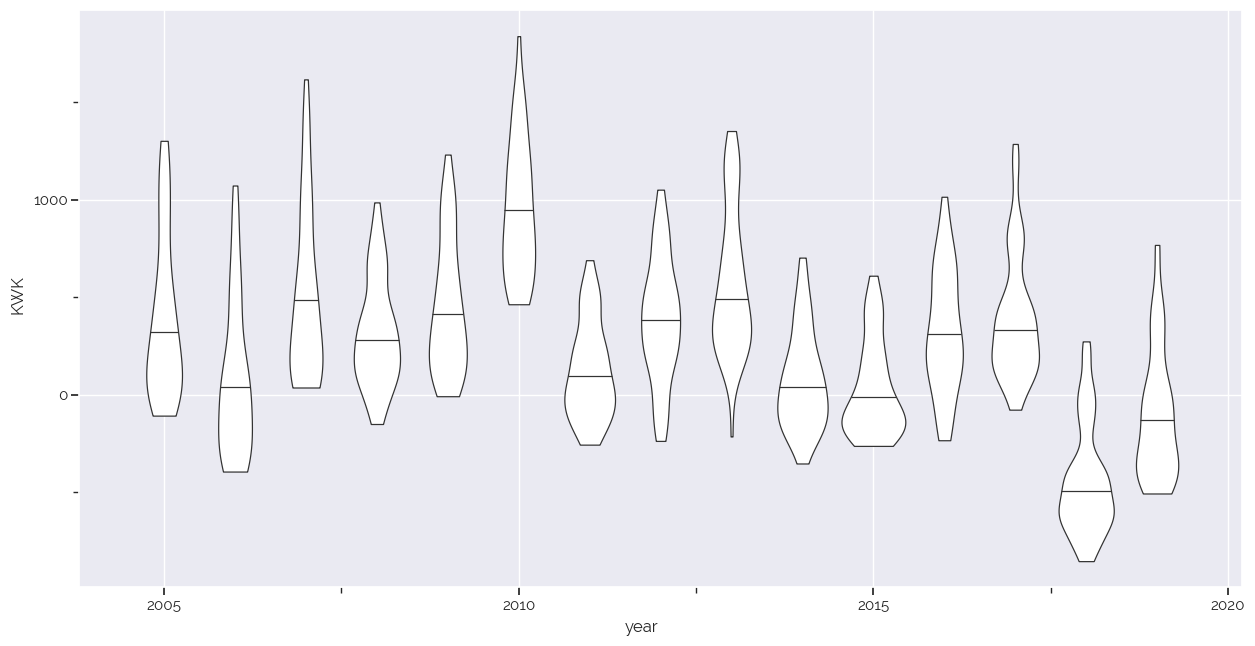

In [21]:
draw = data[(data['year'].isin(range(2005,2020))) & data['timestamp'].map(lambda x: x.month).isin(range(13))].copy()

draw['KWK'] = draw.groupby(['fdist_newname', 'year'])['KWK'].transform('sum').copy()

draw.drop_duplicates(['year', 'fdist_newname'], inplace=True)

(p9.ggplot(p9.aes('year', 'KWK', group='year'), data=draw)
    + p9.geom_violin(draw_quantiles=(0.5))
    + p9.theme_seaborn()).draw();

In [22]:
def climate_boxplot(param, aggfunc, data=data):
    '''
    TODO: documentation
    '''
    # figure size
    p9.options.figure_size = (15, 5)
    
    # select data from winter 2005/2006 untill winter 2019/2020
    draw = data[data['timestamp'].isin(pd.date_range(start='2005-10-01', end='2020-04-01', freq='M'))].copy()
    
    # make a dummy feature that distinguishes winter and summer
    # winter = months 10,11,12,01,02,03; summer = months 4,5,6,7,8,9
    draw['season'] = draw['timestamp'].map(lambda x: 'winter' if x.month not in range(4,10) else 'summer')
    
    # logically group winters together in 'winteryear' column 
    # winter at end of preceeding year should be grouped with winter at beginning of subsequent year
    # for example winter 2007/2008 should go 'in between' summer 2007 and summer 2008
    # in this case the new column takes both observations and maps them to the preceeding year
    draw['winteryear'] = draw[['year', 'timestamp']].apply(lambda x: x[0] if x[1].month != 3 else x[0]-1, axis=1)
    
    # every data point is aggregated for the year for every forestry district in groupby
    draw[param] = draw.groupby(['fdist_newname', 'season', 'winteryear'])[param].transform(aggfunc).copy()
    draw.drop_duplicates(['winteryear', 'season', 'fdist_newname'], inplace=True)
    
    #plot
    (p9.ggplot(p9.aes('factor(winteryear)', param, fill='factor(season)'), data=draw)
     + p9.geom_boxplot(data=draw[draw['season']=='summer'], 
                       width=.35)
    + p9.geom_boxplot(data=draw[draw['season']=='winter'], 
                      width=.35,
                      position=p9.position_nudge(x=0.5))
     + p9.scale_x_discrete(expand=(0, 0, 0, 1))
     + p9.scale_fill_manual(mycolors[1:3], name='season')
     + p9.xlab('year') + p9.ylab(mylabeller(param))
     + mythemewider
    ).draw();

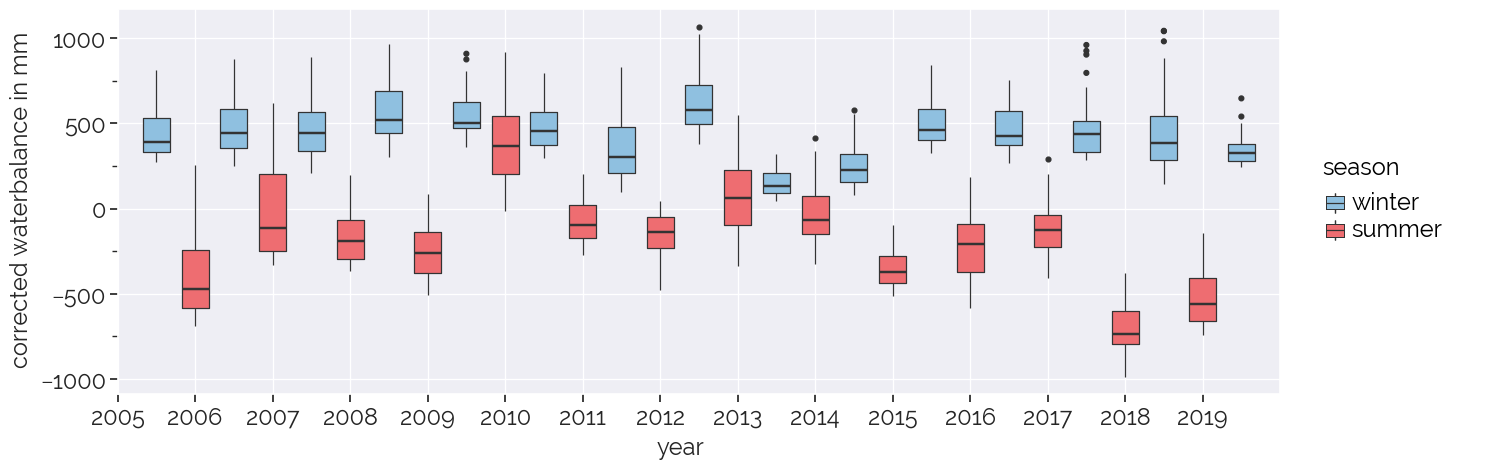

In [23]:
climate_boxplot('KWK', 'sum') # corrected waterbalance (precipitation - evapotranspiration)

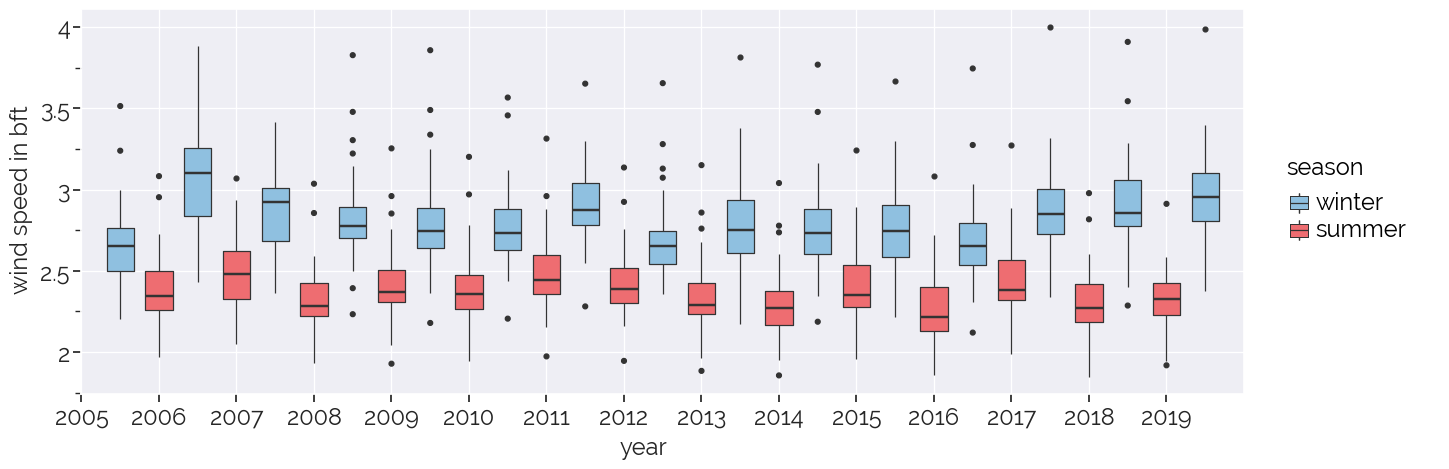

In [24]:
climate_boxplot('FFB', 'mean') # wind speed in bft

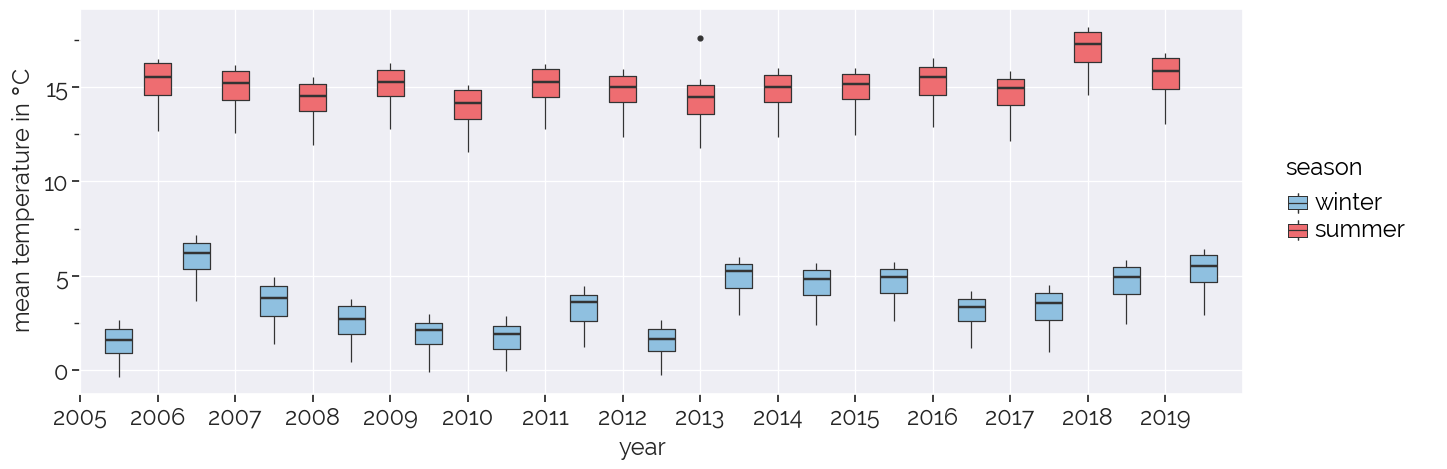

In [25]:
climate_boxplot('TM0', 'mean') # mean temperature

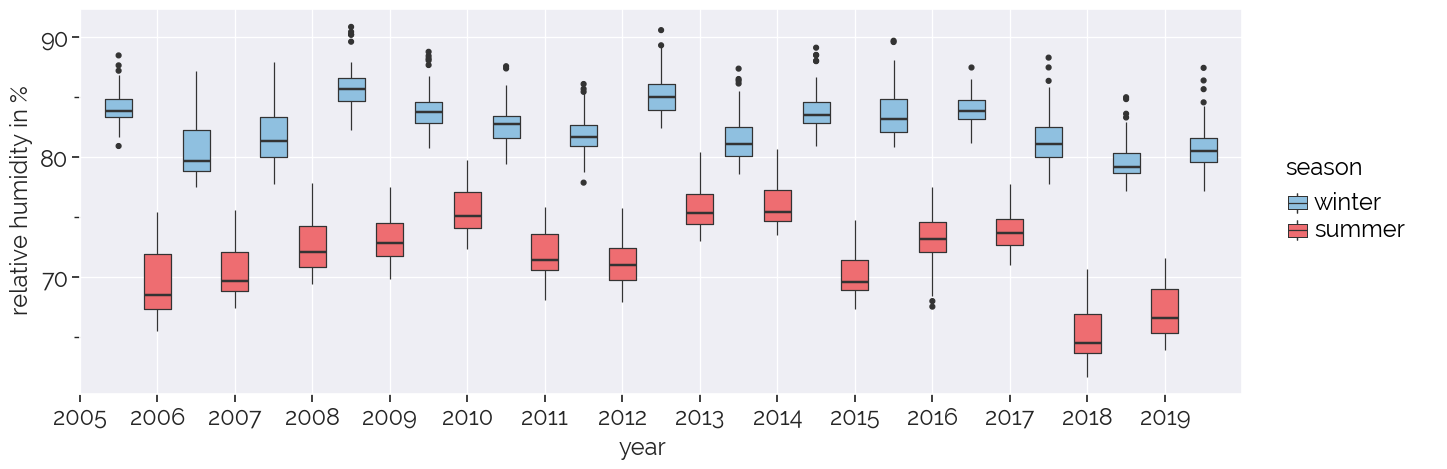

In [26]:
climate_boxplot('RF0', 'mean') # relative humidity

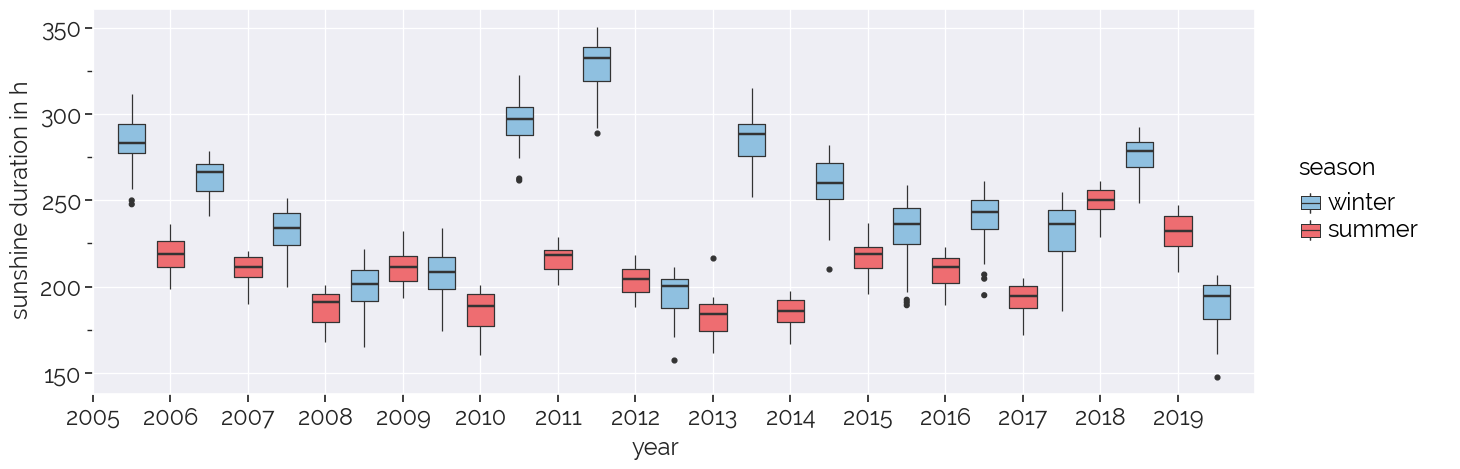

In [27]:
climate_boxplot('SD0', 'mean') # total sunshine duration

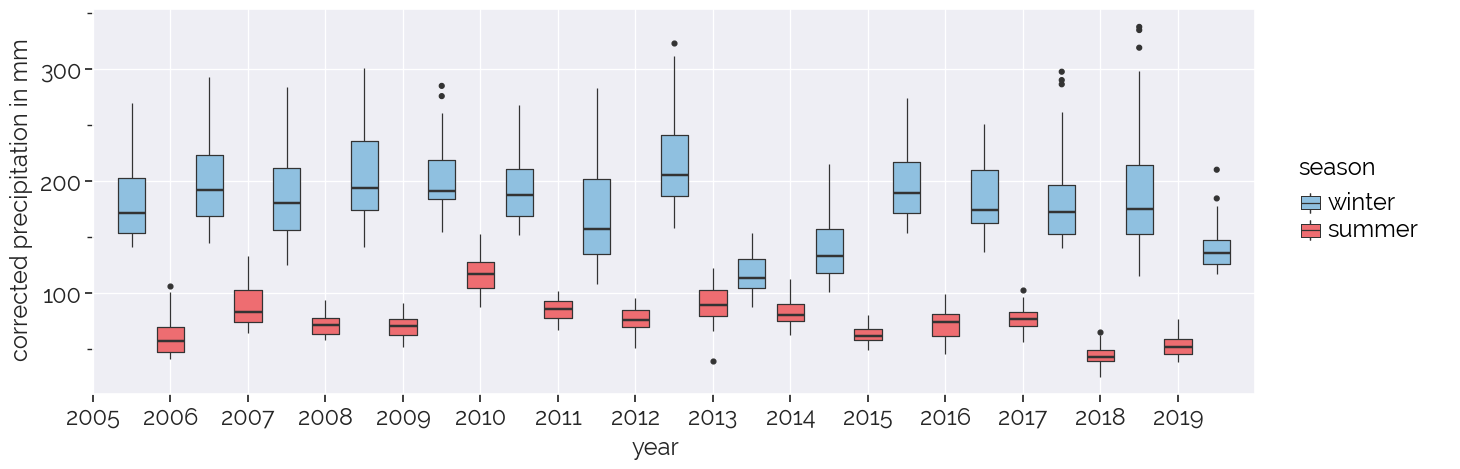

In [28]:
climate_boxplot('RRK', 'mean') # precipitation

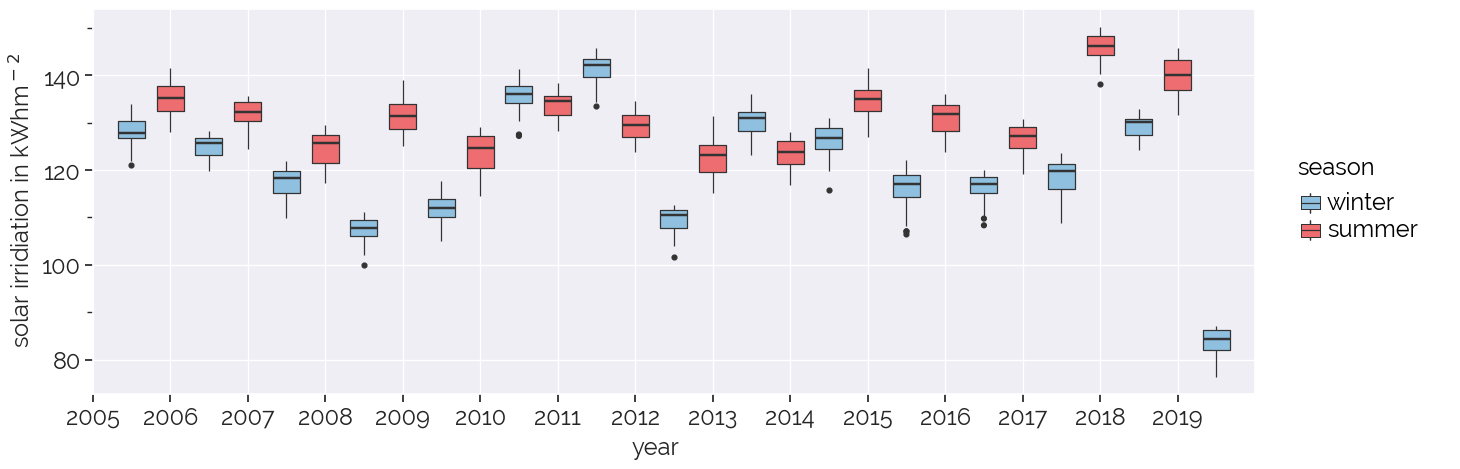

In [29]:
climate_boxplot('RGK', 'mean') # global solar irridiation

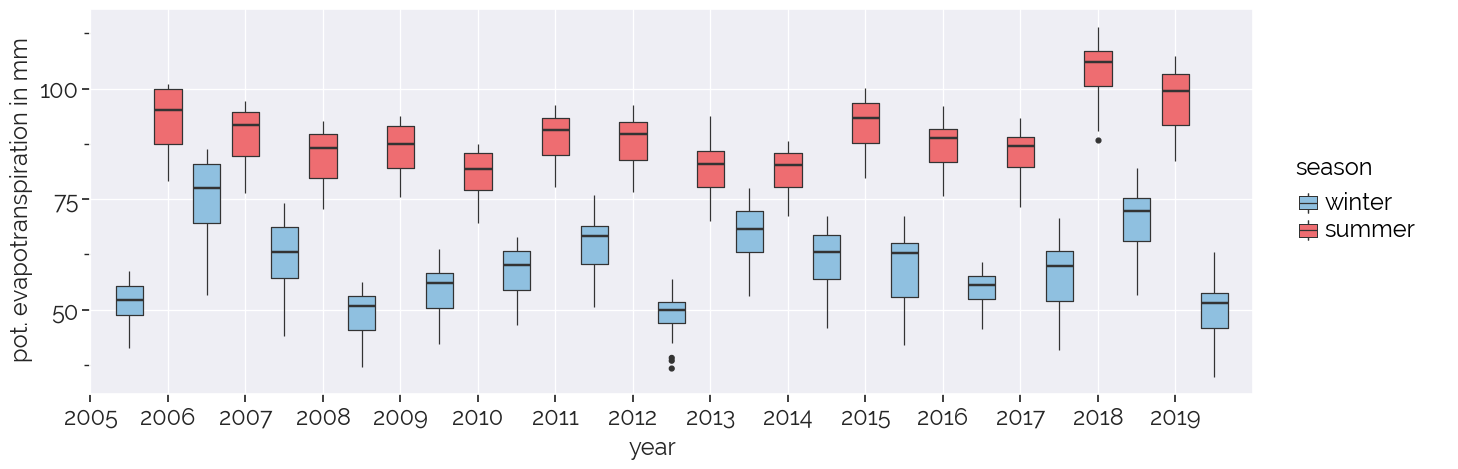

In [30]:
climate_boxplot('GRV', 'mean') # potential evapotranspiration

In [31]:
draw.head()

,fdist_id,year,timeframe,forest_ownership,infested_wood,disposed_wood,county_name,fdist_name,area_nse,area_nsne,area_se,area_sne,centroid_xcoord,centroid_ycoord,area_fdist,endangered_forest_density,TX0,TM0,TN0,RF0,SD0,RRU,RRK,FF1,FF2,FFB,RGK,ETP,GRV,KWU,KWK,HS8,HS16,fdist_newname,id,timestamp,prev_disposed_wood,prev_infested_wood,prev_infested_wood_ofo,TX0_rollyr,TM0_rollyr,TN0_rollyr,RF0_rollyr,SD0_rollyr,RRU_rollyr,RRK_rollyr,FF1_rollyr,FF2_rollyr,FFB_rollyr,RGK_rollyr,ETP_rollyr,GRV_rollyr,KWU_rollyr,KWK_rollyr,prev_infested_wood_rollyr,prev_disposed_wood_rollyr,HS8_rollyr,HS16_rollyr,TX0_rollsr,TM0_rollsr,TN0_rollsr,RF0_rollsr,SD0_rollsr,RRU_rollsr,RRK_rollsr,FF1_rollsr,FF2_rollsr,FFB_rollsr,RGK_rollsr,ETP_rollsr,GRV_rollsr,KWU_rollsr,KWK_rollsr,TX0_rollwr,TM0_rollwr,TN0_rollwr,RF0_rollwr,SD0_rollwr,RRU_rollwr,RRK_rollwr,FF1_rollwr,FF2_rollwr,FFB_rollwr,RGK_rollwr,ETP_rollwr,GRV_rollwr,KWU_rollwr,KWK_rollwr,area_endangered,demolition_wood,disposed_demolition_wood,disposing_rate_demolition,disposing_rate_infested_yr
0,2501,2007,06 Juni,SW,5.0,0.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,24.916160,18.961279,12.705051,69.536366,222.087200,66.932660,72.526601,2.973737,2.187542,2.314478,150.442419,110.063631,116.130629,-43.130978,38.034343,374.090903,374.090903,Elsterheide,Bautzen-Elsterheide-SW,2007-06-30,0.0,0.0,0.0,16.969445,12.008333,6.658670,72.416498,258.143315,96.325082,107.424327,3.881285,2.851936,2.747671,135.472419,91.670115,95.844697,4.653114,15.754209,0.0,NaN,1878.104523,1878.104523,23.674299,17.260886,10.374411,65.548933,246.475863,46.613805,50.651179,3.159596,2.322222,2.404658,144.731032,102.825754,106.099662,-56.215656,-52.174580,3.421530,2.251927,0.980976,26.428021,89.936922,48.678787,54.732491,1.534325,1.127217,1.030228,42.071269,26.838158,28.529911,21.840628,27.894333,26.85,0.0,0.0,1.000000,1.0
6,2501,2008,04 April,SW,1.0,0.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,13.134343,8.478114,3.410774,76.055556,121.405395,67.974406,75.021544,2.989899,2.194276,2.314478,92.019860,56.094611,56.256563,11.879798,82.435019,8.413636,8.413636,Elsterheide,Bautzen-Elsterheide-SW,2008-04-30,0.0,0.0,0.0,14.354910,10.036279,5.425028,76.156510,212.176339,107.609259,119.113271,3.723429,2.739675,2.675140,121.873767,79.747757,81.276039,27.861504,39.365516,19.0,NaN,1531.931805,1531.931805,21.161054,15.610550,9.648597,71.580584,190.639893,73.080807,79.496071,3.203087,2.354770,2.433670,125.470429,87.895175,90.977665,-14.814366,-8.399103,2.516255,1.487336,0.400486,26.910812,77.904262,47.379237,52.910157,1.414590,1.041526,0.972204,39.425702,23.866780,23.858137,23.512458,29.043379,26.85,50.0,25.0,0.500000,NaN
16,2501,2009,01 Januar-März,SW,3.0,3.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,3.875757,1.084624,-2.128171,85.136478,167.395623,145.754215,167.470713,3.820763,2.804377,2.745679,111.766671,61.713807,54.355219,84.040402,121.000686,0.000000,0.000000,Elsterheide,Bautzen-Elsterheide-SW,2009-03-31,0.0,2.0,0.0,13.635157,9.321970,4.679153,78.137262,192.499046,104.937375,117.423065,3.284961,2.410101,2.462542,116.831931,76.455276,73.463440,28.482098,40.967873,10.0,NaN,1432.359093,1432.359093,20.996127,15.256622,9.153423,70.908979,195.974355,55.088720,60.390908,2.824860,2.073737,2.225758,127.692985,89.074859,91.365937,-33.986139,-28.683951,2.091395,1.129106,0.068294,28.455182,63.007912,51.595344,58.151740,1.248354,0.915488,0.899776,35.323626,21.278564,18.520314,30.316778,36.873233,26.85,0.0,0.0,1.000000,NaN
20,2501,2010,07 Juli,SW,0.0,0.0,Bautzen,Elsterheide,11.37,7069.336921,26.85,4707.119357,451775.13571,5.704409e+06,236.375703,16.169175,27.900670,21.678116,14.262289,63.650502,289.538721,100.070365,104.990905,2.557576,1.900000,2.100000,174.654211,132.592251,134.930976,-32.521886,504.478813,442.372731,442.372731,Elsterheide,Bautzen-Elsterheide-SW,2010-07-31,0.0,

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


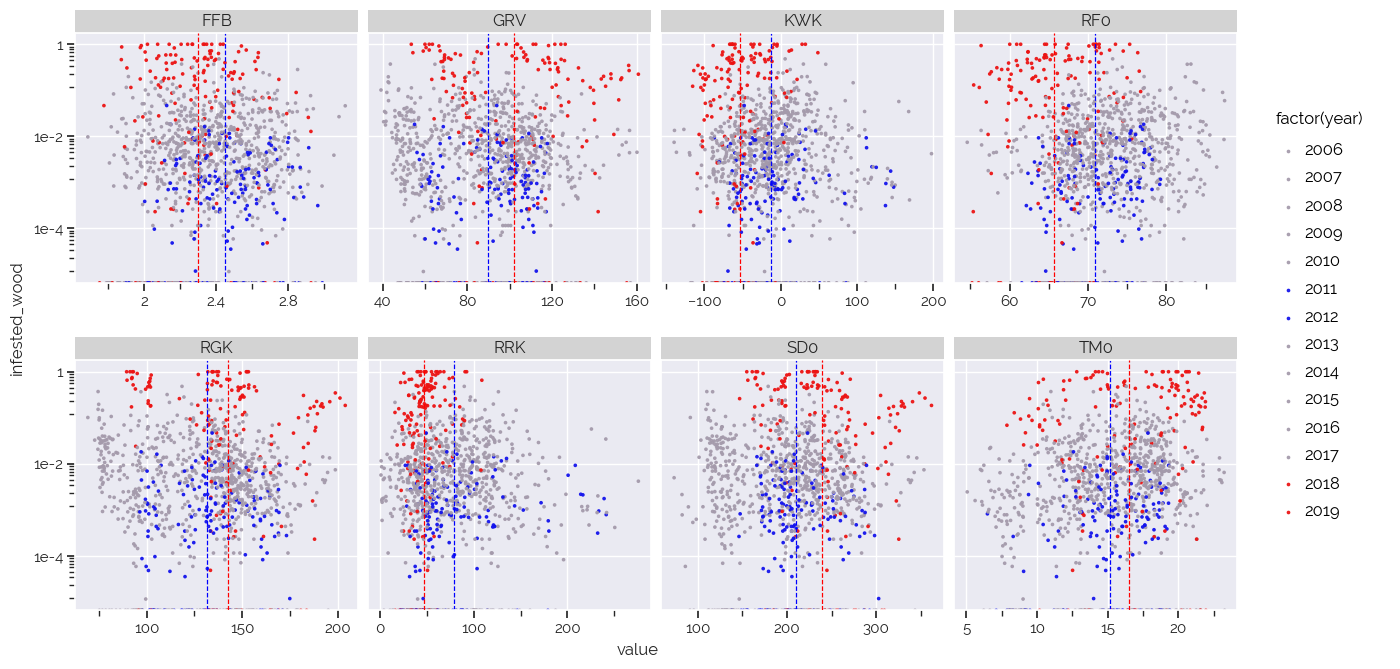

In [32]:
# second graphic -only summer
draw = data.copy()
draw = data[(data['year'].isin(range(2006,2020))) & data['timestamp'].map(lambda x: x.month).isin(range(4,10))].copy()
draw['infested_wood'] = draw.groupby(['county_name', 'timestamp'])['infested_wood'].transform('sum')

for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['county_name', 'timestamp'])[v].transform('mean')

draw.drop_duplicates(['county_name', 'timestamp'], inplace=True)
draw['infested_wood'] = draw.groupby('county_name')['infested_wood'].transform(lambda x: minmax_scale(x))


draw = pd.melt(draw, id_vars=['infested_wood', 'year'], value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])

# vline values
mlow = {}
mhigh = {}


for v in draw.variable.unique():
    ml = np.nanmean(draw.loc[(draw['variable']==v) & (draw['year'].isin([2011, 2012]))]['value'])
    mh = np.nanmean(draw.loc[(draw['variable']==v) & (draw['year'].isin([2018, 2019]))]['value'])
    mlow[f'{v}'] = ml
    mhigh[f'{v}'] = mh


draw['mean_low'] = draw['variable'].map(lambda x: mlow.get(x))
draw['mean_high'] = draw['variable'].map(lambda x: mhigh.get(x))

    # TODO: Legende: 2011, 2012 - 2018, 2019 - other  
p9.options.figure_size = (15,7.5)

(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(p9.aes(color='factor(year)'), size=.5, alpha=.9)
 + p9.facet_wrap('variable', scales='free_x', ncol=4)
 + p9.geom_vline(p9.aes(xintercept='mean_low'), color='blue', linetype='--')
 + p9.geom_vline(p9.aes(xintercept='mean_high'), color='red', linetype='--')
 + p9.theme_seaborn()
 + p9.scale_y_log10()
 + p9.theme(subplots_adjust={'hspace': 0.31})
 + p9.scale_color_manual(['#a49aab', '#a49aab', '#a49aab', '#a49aab', '#a49aab', '#1313ec', '#1313ec', '#a49aab', '#a49aab', '#a49aab', '#a49aab', '#a49aab', '#ec1313', '#ec1313'])
).draw();

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


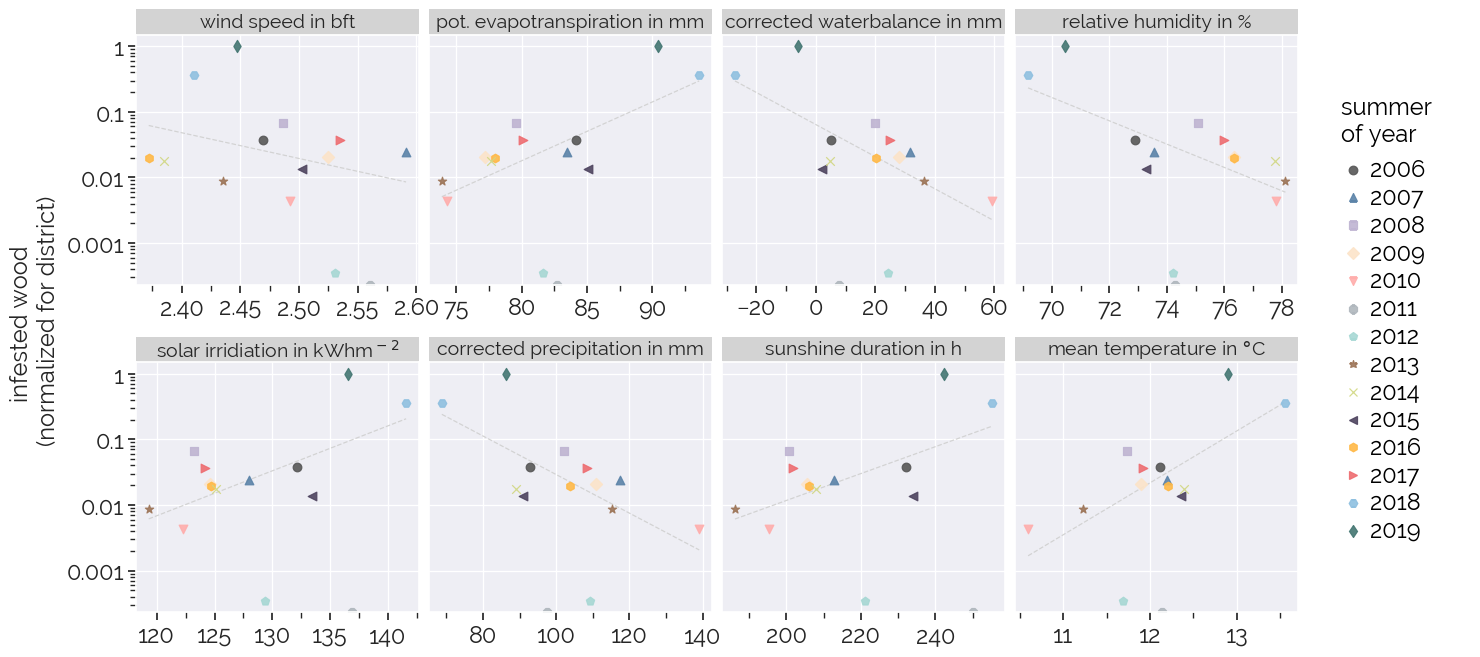

In [33]:
# only one dot per year (whole year, not just summer)
# maybe this is better because it takes the mean of a whole year and does not have individual dots that represent timeframes "ruin" the trend (in july its always warmer)
# 2008 still not special in any way

draw = data[(data['year'].isin(range(2006,2020)))].copy()
draw['infested_wood'] = draw.groupby(['year'])['infested_wood'].transform('mean')

for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['year'])[v].transform('mean')
    
    
draw.drop_duplicates(['year'], inplace=True)
draw['infested_wood'] = draw['infested_wood'].transform(lambda x: minmax_scale(x))
draw = pd.melt(draw, id_vars=['infested_wood', 'year'], value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])


(p9.ggplot(p9.aes('value', 'infested_wood', color='factor(year)', shape='factor(year)'), data=draw)
 + p9.geom_smooth(p9.aes('value', 'infested_wood', group=1), method='lm', se=False, color='lightgrey', size=.5, linetype='--')
 + p9.geom_point(size=3, alpha=.9)
 + p9.facet_wrap('variable', scales='free_x', ncol=4, labeller=mylabeller)
 + p9.xlab('') + p9.ylab('infested wood \n(normalized for district)') 
 + p9.scale_y_log10()
 + p9.scale_color_manual(mycolors[:14][::-1], name='summer \nof year')
 + p9.scale_shape_manual([ 
    'o',  # circle
    '^',  # triangle up
    's',  # square
    'D',  # Diamond
    'v',  # triangle down
    '8',  # octagon
    'p',  # pentagon
    '*',  # star
    'x',  # x
    '<',  # triangle left
    'h',  # hexagon1
    '>',  # triangle right
    'H',  # hexagon1
    'd'   # thin diamond
 ], name='summer \nof year')
 + mythemewide
).draw();

# Other

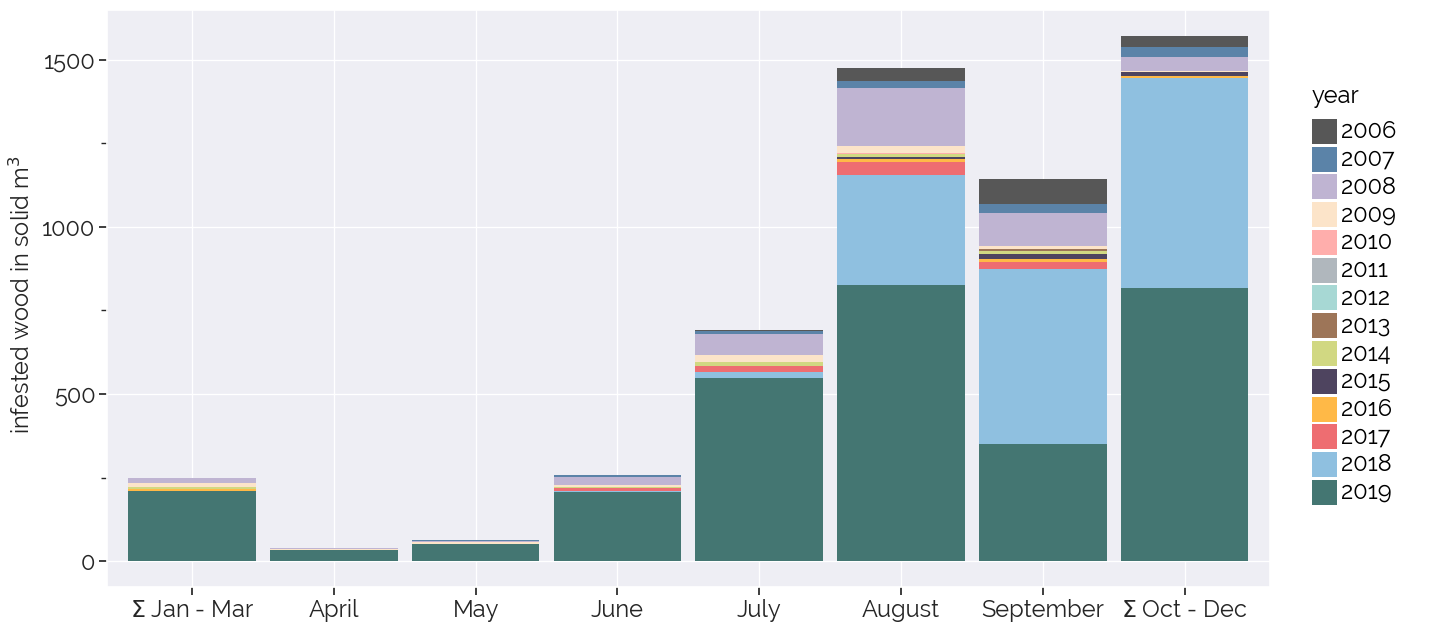

In [34]:
draw = data[(data['year'].isin(range(2006,2020)))].copy()

draw = pd.DataFrame(draw.groupby(['year', 'timeframe'])['infested_wood'].median()).reset_index()
    
(p9.ggplot(p9.aes('timeframe', 'infested_wood', fill='factor(year)'), data=draw)
 + p9.geom_col()
 + p9.scale_x_discrete(labels=[r'$\Sigma$ Jan - Mar', 'April', 'May', 'June', 'July', 'August', 'September', r'$\Sigma$ Oct - Dec'])
 + p9.scale_fill_manual(mycolors[:14][::-1], name='year')
 + p9.xlab('') + p9.ylab(r'infested wood in solid m$^3$')
 + mythemewide
).draw();

C:\Users\Yannic\.conda\envs\python377\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 108 rows containing missing values.


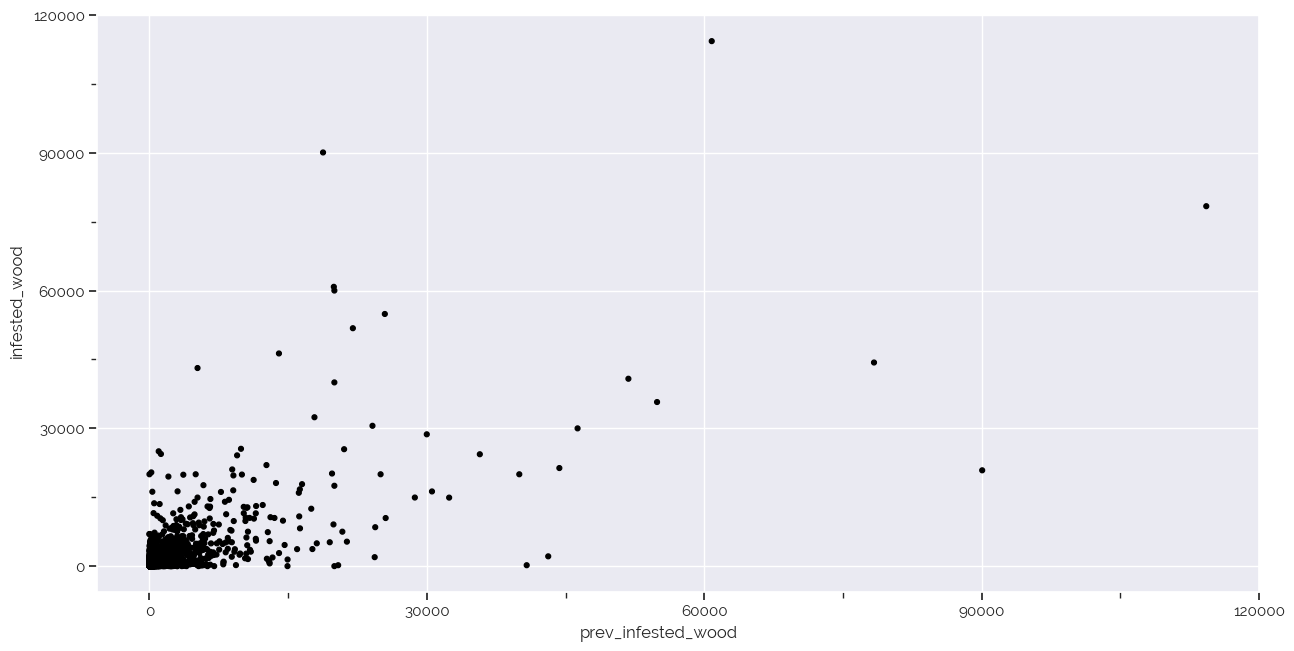

In [36]:
(p9.ggplot(p9.aes('prev_infested_wood', 'infested_wood'), data=data)
 + p9.geom_point()
 + p9.theme_seaborn()
).draw();

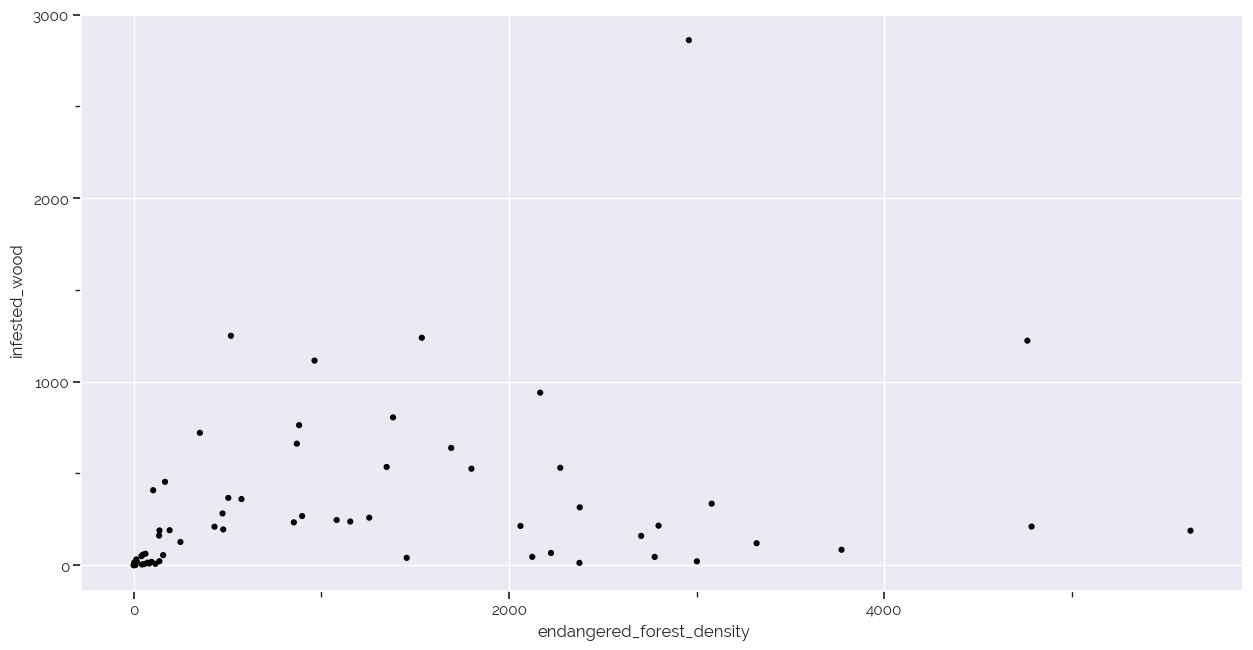

In [37]:
draw = pd.DataFrame(data.groupby('endangered_forest_density')['infested_wood'].mean().reset_index())

(p9.ggplot(p9.aes('endangered_forest_density', 'infested_wood'), data=draw)
 + p9.geom_point()
 + p9.theme_seaborn()
).draw();